In [34]:
# %load /Users/facai/Study/book_notes/preconfig.py
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import scipy as sp

import pandas as pd
pd.options.display.max_rows = 20

逻辑回归算法简介和Python实现
=========================

### 0. 实验数据

In [35]:
names = [("x", k) for k in range(8)] + [("y", 8)]
df = pd.read_csv("./res/dataset/pima-indians-diabetes.data", names=names)
df.head(3)

x                                   y
   0    1   2   3  4     5      6   7  8
0  6  148  72  35  0  33.6  0.627  50  1
1  1   85  66  29  0  26.6  0.351  31  0
2  8  183  64   0  0  23.3  0.672  32  1

### 1. 二分类

#### 1.0 基本原理

ref: http://www.robots.ox.ac.uk/~az/lectures/ml/2011/lect4.pdf

逻辑回归，是对线性分类 $f(x) = w^T x + b$ 结果，额外做了sigmoid变换$\sigma(x) = \frac1{1 + e^x}$。加了sigmoid变换，更适合于做分类器，效果见下图。

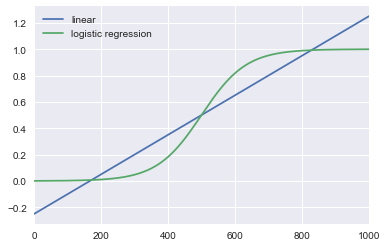

In [36]:
x = np.linspace(-1.5, 1.5, 1000)

y1 = 0.5 * x + 0.5
y2 = sp.special.expit(5 * x)

pd.DataFrame({'linear': y1, 'logistic regression': y2}).plot()

所以，逻辑回归的定义式是

\begin{equation}
  g(x) = \sigma(f(x)) = \frac1{1 + e^{-(w^T x + b)}}
\end{equation}

那么问题来了，如何找到参数$w$呢？

##### 1.0.0 损失函数

在回答如何找之前，我们得先定义找什么：即什么参数是好的？

观察到，对于二分类 $y \in \{-1, 1\}$，有

\begin{align}
  g(x) & \to 1 \implies y = 1 \\
  1 - g(x) & \to 1 \implies y = 0
\end{align}

可以将$g(x)$看作是$y = 1$的概率值，$1 - g(x)$看作是$y = 0$的概率值，整理为：

\begin{align}
  P(y = 1 | x, w) &= g(x) & &= \frac1{1 + e^{-z}} &= \frac1{1 + e^{-y z}} \\
  P(y = 0 | x, w) &= 1 - g(x) &= 1 - \frac1{1 + e^{-z}} &= \frac1{1 + e^z} &= \frac1{1 + e^{-y z}} \\
\end{align}

即，可合并为 $P(y|x, w) = \frac1{1 + e^{-y z}}$，其中$z = w^T x + b$。

好了，常理而言，我们可以认为，对于给定的$x$，有$w$，使其对应标签$y$的概率值越大，则此$w$参数越好。

在训练数据中是有许多样本的，即有多个$x$，如何全部利用起来呢？

假定样本间是独立的，最直接的想法是将它们的预测概率值累乘，又称[Maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation)

\begin{equation}
{\mathcal {L}}(\theta \,;\,x_{1},\ldots ,x_{n})=f(x_{1},x_{2},\ldots ,x_{n}\mid \theta )=\prod _{i=1}^{n}f(x_{i}\mid \theta )
\end{equation}

好，我们用这个方法来描述最合适的参数$w$是

\begin{align}
  w &= \operatorname{arg \ max} \prod_i^n P(y_i | x_i, w) \\
    &= \operatorname{arg \ min} - \log \left ( \prod_i^n P(y_i | x_i, w) \right ) \quad \text{用negative log likelihood转成极小值} \\
    & = \operatorname{arg \ min} - \log \left ( \prod_i^n \frac1{1 + e^{-y z}} \right ) \\
    & = \operatorname{arg \ min} \sum_i^n - \log \left ( \frac1{1 + e^{-y z}} \right ) \\
    & = \operatorname{arg \ min} \sum_i^n \log ( 1 + e^{-y z} ) \\
\end{align}

于是，我们可以定义损失函数

\begin{equation}
  L(w) = \log (1 + e^{-y z}) = \log \left ( 1 + e^{-y (w^T x + b)} \right )
\end{equation}

最好旳$w$值是$\operatorname{arg \ min} L(w)$。

##### 1.0.1 一阶导数

知道找什么这个目标后，怎么找就比较套路了。因为定义了损失函数，很自然地可以用数值寻优方法来寻找。很多数值寻优方法需要用到一阶导数信息，所以简单对损失函数求导，可得:

\begin{align}
  \frac{\partial L}{\partial w} &= \frac1{1 + e^{-y (w^T x + b)}} \cdot e^{-yb} \cdot -yx e^{-y w^T x} \\
    &= \frac{e^{-y (w^T x + b)}}{1 + e^{-y (w^T x + b)}} \cdot -y x \\
    &= -y \left ( 1 - \frac1{1 + e^{-y (w^T x + b)}} \right ) x
\end{align}


有了损失函数和导数，用数值寻优方法就可找到合适的$w$值，具体见下一节的演示。

#### 1.1 实现演示

上一节，我们得到了损失函数和导数：

\begin{align}
  L(w) &= \log \left ( 1 + e^{-y (w^T x + b)} \right ) \\
  \frac{\partial L}{\partial w}  &= -y \left ( 1 - \frac1{1 + e^{-y (w^T x + b)}} \right ) x
\end{align}

对于$n$个训练样本，需要加总起来：

\begin{align}
  L(w) &= \sum_i^n \log \left ( 1 + e^{-y (w^T x + b)} \right ) \\
  \frac{\partial L}{\partial w} &= \sum_i^n -y \left ( 1 - \frac1{1 + e^{-y (w^T x + b)}} \right ) x
\end{align}

注意：导数是个向量。

我们可以用矩阵运算，来替换掉上面的向量运算和累加。

令有训练集$\mathbf{X} = [x_0; x_1; \dots; x_n]^T$，其中毎个样本长度为$m$，即有$x_0 = [x_0^0, x_0^1, \dots, x_0^m]$。对应有标签集$y = [y_0, y_1, \dots, y_n]^T$。

令参数值$w$，矩阵乘法记为$\times$，向量按元素相乘记为$\cdot$，则可改写前面公式为：

\begin{align}
  z &= \exp \left ( -y \cdot (X \times w) \right ) \\
  L(w) &= \sum \log (1 + z) \\
  \frac{\partial L}{\partial w} &= (-y \cdot (1 - \frac1{1 + z}))^T \times X
\end{align}

依上式写函数如下：

In [37]:
def logit_loss_and_grad(w, X, y):
    w = w[:, None] if len(w.shape) == 1 else w
    
    z = np.exp(np.multiply(-y, np.dot(X, w)))
    loss = np.sum(np.log1p(z))
    grad = np.dot((np.multiply(-y, (1 - 1 / (1 + z)))).T, X)
    
    return loss, grad.flatten()

In [38]:
# 测试数据
X = df["x"].as_matrix()
# 标签
y = df["y"].as_matrix()

In [39]:
# 初始权重值
w0 = np.zeros(X.shape[1])

In [40]:
# 演示一轮损失函数和导数值
logit_loss_and_grad(w0, X, y)

(532.33703467003795,
 array([  -652.   , -18928.5  ,  -9490.5  ,  -2970.   , -13445.   ,
         -4709.1  ,    -73.767,  -4967.   ]))

In [41]:
# 调过数值寻优方法，求解得到w 

(w, loss, info) = sp.optimize.fmin_l_bfgs_b(logit_loss_and_grad, w0, args=(X, y))

w

array([ 0.02490757,  0.72310265,  0.36255412,  0.11345933,  0.51362311,
        0.17989607,  0.00281803,  0.18974831])

In [42]:
# 预测概率值
y_pred_probability = 1 / (1 + np.exp(np.multiply(-y, np.dot(X, w[:, None]))))
# 预测结果
y_pred = (y_pred_probability >= 0.5).astype(int)

In [43]:
from sklearn.metrics import accuracy_score, auc, precision_score

In [44]:
# 预测准确度
accuracy_score(y, y_pred)

0.34895833333333331

In [45]:
auc(y, y_pred_probability, reorder=True)

0.75

好了，到此，就完成了二分类的演示。

### 2. 多分类

#### 2.0 基本原理

前面讲到二分类借助的是logistic function，当问题推广到多分类时，自然而然想到就可借助[softmax functioin](https://en.wikipedia.org/wiki/Softmax_function)。

> In mathematics, the softmax function, or normalized exponential function, is a generalization of the logistic function）$\sigma (\mathbf {z} )_{j}={\frac {e^{z_{j}}}{\sum _{k=1}^{K}e^{z_{k}}}}$

可以看到softmax本身是很简单的形式，它要求给出模型预测值$e^{z_k}$，归一化作为概率值输出。所以只要指定这个$e^{z_k}$是线性模型$\beta_0 + \beta x$，问题就解决了。具体见下面。

对于K分类问题，假设有样本$x$，标签$y \in \{0, 1, 2, ..., K - 1\}$。我们将$y = 0$选为标杆，得到K-1个线性模型：

\begin{align}
  \log \frac{P(y = 1 | x)}{P(y = 0 | x)} &= \beta_{10} + \beta_1 x \\
  \cdots \\
  \log \frac{P(y = K - 1 | x)}{P(y = 0 | x)} &= \beta_{(K-1)0} + \beta_{K-1} x \\
\end{align}

特别地，用同样的式子列写$y = 0$，可得到

\begin{align}
  \log \frac{P(y = 0 | x)}{P(y = 0 | x)} &= \log(1) \\
    & = 0 \\
    & = 0 + [0, 0, \dots, 0] x \\
    & = \beta_{00} + \beta_0 x \quad \text{令$\beta_0$是零阵} \\
\end{align}

也就是说，令$\beta_0$是零阵，则可以将上面式子统一写为

\begin{equation}
  \log \frac{P(y = k | x)}{P(y = 0 | x)} = \beta_{k0} + \beta_k x
\end{equation}

即有 $P(y = k | x) = e^{\beta_{k0} + \beta_k} x P(y = 0 | x)$，   
又概率相加总为1，$\sum_k P(y = k | x) = 1$，两式联立可得:

\begin{equation}
  P(y = k | x) = \frac{e^{\beta_{k0} + \beta_k x}}{\sum_i e^{\beta_{i0} + \beta_i x}}
\end{equation}

我们希望模型参数$\beta$使对应的$P(y | x, \beta)$时越大越好，所以，可定义损失函数为

\begin{align}
  L(\beta) &= -log P(y = k | x, \beta) \\
    &= \log(\sum_i e^{\beta_{i0} + \beta_i x)} - (\beta_{k0} + \beta_k x)
\end{align}

再求得一阶导数

\begin{align}
  \frac{\partial L}{\partial \beta} &= \frac1{\sum_i e^{\beta_{i0} + \beta_i x} x} e^{\beta_{k0} + \beta_k x} - x I(y = k) \\
    &= x \left ( \frac{e^{\beta_{k0} + \beta_k x}}{\sum_i e^{\beta_{i0} + \beta_i x}} - I(y = k) \right ) \\
\end{align}

有了损失函数和一阶导数，同样地，可以使用数值优化法来寻优。上面的式子容易溢出，相应的变形见[逻辑回归在spark中的实现简介](./spark_ml_lr.ipynb)第2.2节。


#### 2.1 特例

令$K=2$，代入多分类式子：

\begin{align}
  P(y = 1 | x) &= \frac{e^{\beta_{k0} + \beta_k x}}{\sum_i e^{\beta_{i0} + \beta_i x}} |_{k = 1} \\
    &= \frac{e^{\beta_{10} + \beta_1 x}}{e^{\beta_{00} + \beta_0 x} + e^{\beta_{10} + \beta_1 x}}  \\
    &= \frac{e^{\beta_{10} + \beta_1 x}}{1 + e^{\beta_{10} + \beta_1 x}}  \\
    &= \frac1{1 + e^{- (\beta_{10} + \beta_1 x)}}  \\
    &= \frac1{1 + e^{- (w^T x + b)}}  \\
\end{align}

可以看到，二分类逻辑回归只是多分类的特例。

### 3.0 小结

本文简要介绍了逻辑回归二分类和多分类的理论表达式，并对二分类做了代码演示。